In [1]:
import pandas as pd
import xgboost as xgb

%matplotlib inline

/home/jayant/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# read data
trainset = pd.read_csv("data/train.csv")
testset = pd.read_csv("data/test.csv")

In [5]:
# combine test and train set for feature extraction
data = trainset.append(testset)

In [77]:
# Generate features

# named or not
data["is_named"] = data.Name.apply(lambda x: 0 if pd.isnull(x) else 1)

# Age in days
day_map = {"year": 365, "years": 365, "months":30, 'weeks': 7, 'month':30, 'days':1, 'week':7, 'day':1, 'nan': 0}
suffix = data.AgeuponOutcome.apply(lambda x: str(x).split()[1] if len(str(x).split()) > 1 else x ).apply(lambda x: day_map[str(x)])
prefix = data.AgeuponOutcome.apply(lambda x: str(x).split()[0]).replace('nan', '0').apply(lambda x: int(x))
data["age_in_days"] = prefix * suffix

# Mix Breed
# data["mix_breed"] = data.Breed.apply(lambda x: 1 if "Mix" in str(x) else 0)
# mix breed isn't really good according to f-score, domestic breed is a better metric

# Domestic Breed
data["domestic_breed"] = data.Breed.apply(lambda x: 1 if "Domestic" in str(x) else 0)

# Gender and Spayed
data["gender"] = data.SexuponOutcome.apply(lambda x: 1 if "Male" in str(x) else 0)

# Convert Categorical text to numbers
convert_cols = ["AnimalType", "Breed", "Color", "SexuponOutcome"]
for col in convert_cols:
    value_map = { key: index for index, key in enumerate(data[col].unique()) }
    data[col + "Encoded"] = data[col].apply(lambda x: value_map[x])

processed_cols = "gender domestic_breed is_named 	age_in_days 	AnimalTypeEncoded 	BreedEncoded 	ColorEncoded 	OutcomeType 	SexuponOutcomeEncoded".split()
processed_data = data[processed_cols]

In [78]:
# split the train and test set
processed_trainset = processed_data[:len(trainset.index)]
processed_testset = processed_data[len(trainset.index):len(trainset.index) + len(testset.index)]

In [79]:
# encode OutcomeType
value_map = { key: index for index, key in enumerate(processed_trainset.OutcomeType.unique()) }
processed_trainset["OutcomeType"] = processed_trainset.OutcomeType.apply(lambda x: value_map[x])

/home/jayant/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [84]:
# Separate Features and predictions for training
train_cols = ['is_named',
 'age_in_days',
 'AnimalTypeEncoded',
 'BreedEncoded',
 'ColorEncoded',
 'SexuponOutcomeEncoded',
 'domestic_breed']
pred_col = "OutcomeType"
X_train, y_train = processed_trainset[train_cols], processed_trainset[pred_col]
X_test, y_test = processed_testset[train_cols], processed_testset[pred_col]

In [85]:
# Convert to xgb matrix
dtrain = xgb.DMatrix(X_train.as_matrix(), label=y_train.as_matrix(), feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test.as_matrix(), label=y_test.as_matrix(), feature_names=X_test.columns)

In [86]:
# cv runs
params = {'max_depth':5, 'objective':'multi:softprob', 'num_class':5, 'eval_metric':'mlogloss'}
xgb.cv(params, dtrain, as_pandas=True, early_stopping_rounds=10, nfold=10, num_boost_round=50)

Will train until cv error hasn't decreased in 10 rounds.
Stopping. Best iteration: 36


,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.333953,0.005491,1.331600,0.000878
1,1.186644,0.008368,1.182867,0.001176
2,1.092376,0.010598,1.086602,0.001553
3,1.028172,0.012123,1.020919,0.001643
4,0.982660,0.013300,0.974206,0.001719
5,0.949977,0.014074,0.940034,0.001657
6,0.926004,0.014722,0.914439,0.001632
7,0.908147,0.015467,0.894960,0.001611
8,0.894489,0.016029,0.879731,0.001581
9,0.883846,0.016076,0.867671,0.001706


In [87]:
bst = xgb.train(params, dtrain)

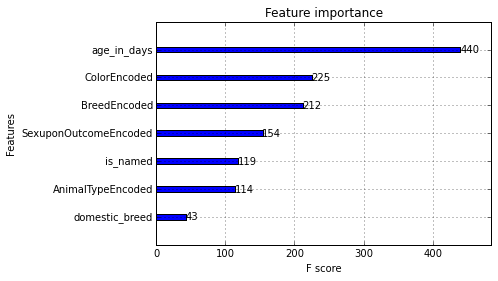

In [88]:
xgb.plot_importance(bst)

In [89]:
# predict and convert to df
predictions = bst.predict(dtest)
predictions_df = pd.DataFrame(predictions,columns=sorted(value_map, key=lambda k: value_map[k]))
predictions_df["ID"] = predictions_df.index
predictions_df.ID = predictions_df.ID.apply(lambda x: x+1)
predictions_df.head()

,Return_to_owner,Euthanasia,Adoption,Transfer,Died,ID
0,0.298253,0.061809,0.058389,0.546489,0.035060,1
1,0.297257,0.048004,0.461786,0.158249,0.034703,2
2,0.123467,0.054830,0.412388,0.373325,0.035990,3
3,0.147034,0.052989,0.136057,0.628292,0.035628,4
4,0.304567,0.052019,0.427390,0.178419,0.037605,5


In [90]:
predictions_df.to_csv("predictions_v4.csv",  index=False)